**Author: Nico Grisouard, nicolas.grisouard@physics.utoronto.ca**

*Supporting textbook chapters for week 5: Chapter 7.*

**Lecture 5, topics:**
* Discrete Fourier Transforms (DFTs)
* Fast Fourier Transforms (FFTs)

# Fourier series: reminders

We can express a periodic function on an interval $[0, L]$ as a Fourier series.
$$f(x) = \sum_{k=0}^{\infty}\left[\alpha_k \cos\left(\frac{2\pi k x}{L}\right) + \beta_k\sin\left(\frac{2\pi k x}{L}\right)\right]$$
$$= \sum_{k=-\infty}^{\infty}\gamma_k \exp\left(i\frac{2\pi k x}{L}\right),\qquad\qquad\quad $$
with 
$$\gamma_k = \frac12\left(\alpha_{-k} + i\beta_{-k}\right)\quad \text{if}\quad k<0,$$
$$\gamma_k = 0 \quad\qquad\qquad\quad \text{if}\quad k=0,$$
$$\gamma_k = \frac12\left(\alpha_{k} - i\beta_{k}\right)\quad\quad \text{if}\quad k>0,$$
and
$$\forall k, \quad \gamma_k = \frac1L\int_0^L f(x)\exp\left(-i\frac{2\pi k x}{L}\right)dx\quad \text{from orthogonality of sin functions}.$$

Orthogonality of the sine functions:
$$\int_0^L\sin\left(\frac{\pi n x}{L}\right)\sin\left(\frac{\pi m x}{L}\right)dx = \frac{L}2 \delta_{nm},$$
$$\int_0^L\cos\left(\frac{\pi n x}{L}\right)\cos\left(\frac{\pi m x}{L}\right)dx = \frac{L}2 \delta_{nm},$$
$$\int_0^L\sin\left(\frac{\pi n x}{L}\right)\cos\left(\frac{\pi m x}{L}\right)dx= 0$$

Even for non-periodic functions, we can repeat the function over the portion of interest and discard the rest.
Below are two pictures, one representing a plucked string, and the other representing the same from, as if it was part of a bigger, infinitely periodic function.

Here is Newman's take on it:
![Newman's fig. 7.1](fig7-1.png)

# Discrete Fourier Transform

## Principle

* Now let's think about the integral used for obtaining the $\gamma_k$'s.
* We divide $[0, L]$ up into $N$ segments and use the trapezoidal rule and periodicity of the function:

$$
\begin{align*}
\gamma_k & = \frac1L \int_0^L f(x)\exp\left(-i\frac{2\pi k x}{L}\right) dx \\
         & \approx \frac1L \frac{L}N\left[\frac12 f(0) + \frac12 f(L) + \sum_{n=1}^{N-1} f(x_n) \exp\left(-i\frac{2\pi k x_n}{L}\right) \right] \\
         & = \frac1N \left[\sum_{n=0}^{N-1} f(x_n) \exp\left(-i\frac{2\pi k x_n}{L}\right) \right] \quad \text{because }f(0) = f(L)
\end{align*}
$$

* Now define the Discrete Fourier Transform (DFT) as follows:
$$y_k = f(x_k); \qquad c_k = N\gamma_k;$$
$$
\begin{align*}
\text{DFT:}&\quad c_k = \sum_{n=0}^{N-1}y_n \exp\left(-i\frac{2\pi kn}{N}\right) \Rightarrow c_k = c_{N-k}^* \text{ for }y(x)\in \mathbb{R}.\\
\text{iDFT:}&\quad y_n = \frac1N \sum_{k=0}^{N-1}c_k \exp\left(i\frac{2\pi kn}{N}\right).
\end{align*}
$$

* The inverse DFT follows from the definition of the DFT and properties of exponential sums.

Note how 
$$\text{DFT:} \quad c_k = \sum_{n=0}^{N-1} y_n \exp\left(-i\frac{2\pi k n}{N}\right)$$ 
$$\Rightarrow c_k = c_{N-k}^* \text{ for }y(x)\in \mathbb{R}.$$

* If $y(x)\in \mathbb{R}$, then we only need $N/2 + 1$ ($N$ even) or $(N+1)/2$ ($N$ odd) points to actually know the DFT.
* Python's `N//2+1` will give you this number.

In [2]:
N = 4
print('N//2+1 = ' + str(N//2 + 1))

N//2+1 = 3


## An implementation of the DFT

See the script `dft_ts.py`, adapted from Newman's online material.

In [3]:
# %load dft_ts.py
# Adapted from Newman's dft script
import numpy as np
import pylab as plt

def dft(y):
    N = len(y)
    c = np.zeros(N//2+1, complex)
    for k in range(N//2+1):
        for n in range(N):
            c[k] += y[n]*np.exp(-2j*np.pi*k*n/N)
    return c

In [4]:
y = plt.loadtxt("pitch.txt",float)
plt.subplot(211)
plt.plot(y)
plt.title('pitch timeseries')
plt.grid()

c = dft(y)
plt.subplot(212)
plt.plot(abs(c))
plt.title('amplitude of Fourier coefficients')
plt.xlim(0, 500)
plt.grid()

plt.tight_layout()
plt.savefig('timeseries.png', dpi = 100)
plt.close()

![The physical signal (top) and its DFT (bottom)](timeseries.png)

# Fast Fourier Transforms

## Can we speed up the DFT?

$$\text{Recall}\qquad c_k = \sum_{n=0}^{N-1} y_n \exp\left(-i\frac{2\pi k n}{N}\right) $$

* The `dft` snippet below requires $O(N^2)$ operations.

In [5]:
for k in range(N//2+1):
    for n in range(N):
        c[k] += y[n]*np.exp(-2j*np.pi*k*n/N)

* To run a billion operations, $N \sim 32,\!000$: too few to be practical.
* The Fast Fourier Transform (FFT) overcomes this (Cooley & Tukey in 1960’s, first found by Gauss in 1805).

## FFTs divide and conquer

Assume $N=2^m$ (other prime numbers in the decomposition are possible, but they will slow down the execution).
$$\text{Split}\qquad c_k = \sum_{n=0}^{N-1} y_n \exp\left(-i\frac{2\pi k n}{N}\right) = E_k + \omega O_k,$$
with 
$$
\begin{align*}
E_k & = \sum_{p=0}^{N/2-1} y_{2p} \exp\left(-i\frac{2 p\pi k }{N/2}\right)\quad \text{the even indices,}\\
O_k & = \sum_{p=0}^{N/2-1} y_{2p+1} \exp\left(-i 2p\frac{\pi k}{N/2}\right)\quad \text{the odd indices, and}\\
\omega & = \text e^{-i2\pi k/N}\quad \text{the "twiddle factor"}.
\end{align*}
$$

$$\text{Split}\qquad c_k = \sum_{n=0}^{N-1} y_n \exp\left(-i\frac{2\pi k n}{N}\right) = E_k + \omega O_k,$$
* $E_k$ and $O_k$ represent DFTs over points sampled twice as far apart as the original interval.
* If we stopped here: \# of operations would be $2\times (N/2)^2 + 2 = N^2/2$ + 2 (bisection + twiddle factor): **a lot less operations for large N!**.
* keep going: $E_k$ and $O_k$ can be split in two (bisected) themselves.
* If $N = 2^M$, after $M = \log_2(N)$ bisections, we get $N$ DFTs of a single sample:
$$c_0 =  \sum_{n=0}^{1-1}y_n\text e^{-i 2\pi k n} = y_0,$$
the value at the sample point!

So, you actually go back:
* take all sample points: that's the 1st set of samples.
* pair them according to the last FFT bisection in the process above,
* multiply the odd pairs by appropriate twiddle factors,
* use these results to work the next set of samples.

* $j$-th set of samples at the $m$-th stage:
$$E_k^{(m,j)} = \sum_{p=0}^{N/2^m - 1}y_{2^m p + j}\exp\left(-i\frac{2\pi k p}{N/2^m}\right),\quad j \in \{0\dots 2^m-1\}$$
Note: all $E_k$ and $O_k$ of previous slides are now some $E_k^{(m, j)}$.
* $2^m = $ \# of FTs at each level (indexed by $j$),
* $N/2^m = $ \# of samples per intermediate FT (indexed by $k$),
* Recursively, working from $M = \log_2 N$:
    * First step: $E_k^{(M, j)} = y_j$ (no $k$ dependence), **ops:** $N$
    * Next steps: $E_k^{(m, j)} = E_k^{(m+1, j)} + \omega^{2^m k}E_k^{(m+1, j+2^m)}$, **ops:** $N/2^m \times 2^m = N$
    * Last step: $E_k^{(0, 0)} = c_k$, the desired DFT coefficients. **ops:** $N \times 1 = N$



* We end up with $N$ terms in each of the $\log_2 N$ bisections, so the number of operations is $N\log_2 N$.
* Huge speed increase for large $N$
* For $N=10^6$, old DFT algorithm is $O(N^2) = 10^{12}$ ops, but FFT is $O(N\log_2 N) \sim 2 \times 10^7$ ops.
* Opens door to a wide range of calculations.
* Note that the same reasoning applies to the inverse FT: the algorithm is called the inverse FFT (iFFT).
* You can write your own FFT (see Exercise 7.7).
* But there are good tricks for saving memory that are implemented in packages like `numpy.fft`:

https://docs.scipy.org/doc/numpy-1.13.0/reference/routines.fft.html

* For this lab, we will be using FFTs to calculate DFTs.

See script `fft_ts.py`, which is derived from `dft_ts.py`.

In [6]:
# %load fft_ts.py
# various exercises with dft and fft
import numpy as np
import pylab as plt
from numpy.fft import rfft, irfft
from time import time

pi = np.pi
# function to calculate the dft


def dft(y):
    N = len(y)
    c = np.zeros(N//2+1, complex)
    for k in range(N//2+1):
        for n in range(N):
            c[k] += y[n]*np.exp(-2j*pi*k*n/N)
    return c

dft time   2.09e+00 and fft time   1.38e-02
maximum  |c2-c|:  1.2335006831868961e-11


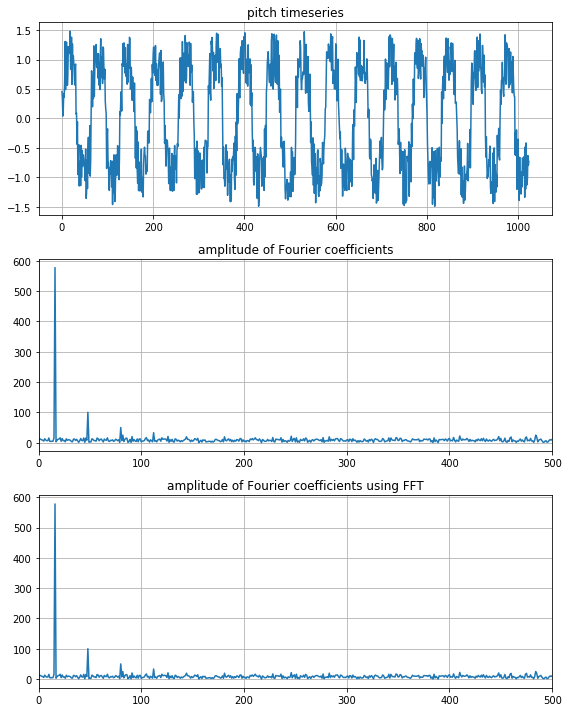

In [7]:
# plot time series and dft
y = plt.loadtxt("pitch.txt", float)

plt.figure(1, figsize=(8, 10))
plt.subplot(3, 1, 1)
plt.plot(y)
plt.title('pitch timeseries')
plt.grid()

dft_time = time()
c = dft(y)
dft_time = time() - dft_time

plt.subplot(3, 1, 2)
plt.plot(abs(c))
plt.title('amplitude of Fourier coefficients')
plt.xlim(0, 500)
plt.grid()

# ------------------
# now do it again with FFT
fft_time = time()
c2 = rfft(y)
fft_time = time() - fft_time

# compare home made dft with fft performance
print('dft time {0:10.2e} and fft time {1:10.2e}'.format(dft_time, fft_time))

# plot
plt.subplot(3, 1, 3)
plt.plot(abs(c2))
plt.title('amplitude of Fourier coefficients using FFT')
plt.xlim(0, 500)
plt.grid()

plt.tight_layout()

print('maximum  |c2-c|: ', max(abs(c2-c)))

top three frequencies and their amplitudes:
    689.06    2067.19    3445.31 Hz
    577.64     100.46      50.24


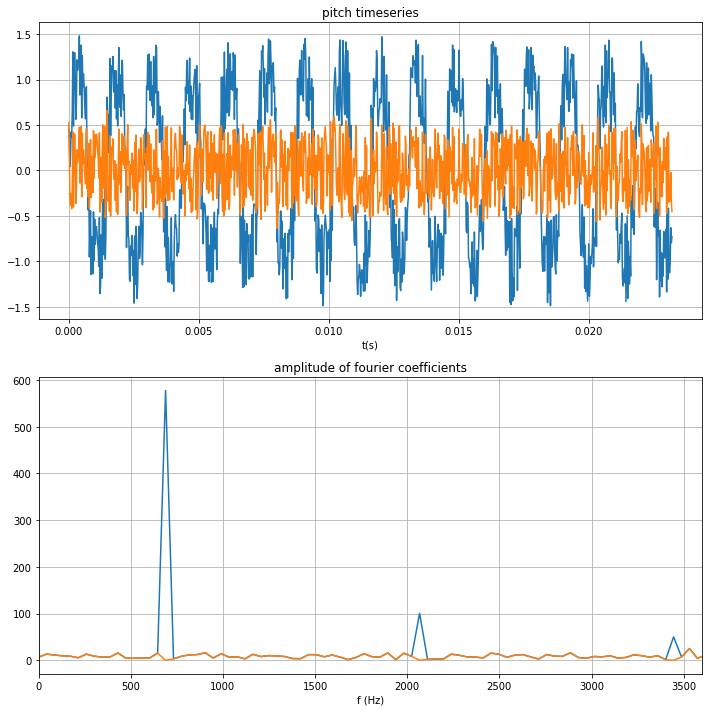

<Figure size 432x288 with 0 Axes>

In [8]:
# now do things with proper time dimensions and filter out desired frequencies
# sampling frequency for audio signal
f = 44100.0  # Hz
# related temporal sample
dt = 1/f  # s
# length of vector
N = len(y)
# length of interval
T = N*dt
# convert to (angular) frequency
freq = np.arange(N/2+1)*2*pi/T
# dimensional time axis
t = np.arange(N)*dt
# sort on maximum frequency
MaxFreqs = np.argsort(abs(c2)**2)  # get indexes of largest three frequencies
MaxFreqs = MaxFreqs[-1:-4:-1]  # retain only top three
print('top three frequencies and their amplitudes:')
print('{0:10.2f} {1:10.2f} {2:10.2f} Hz'.format(
    freq[MaxFreqs[0]]/(2*pi),
    freq[MaxFreqs[1]]/(2*pi),
    freq[MaxFreqs[2]]/(2*pi)))
print('{0:10.2f} {1:10.2f} {2:10.2f}'.format(
    abs(c2[MaxFreqs[0]]), abs(c2[MaxFreqs[1]]), abs(c2[MaxFreqs[2]])))

# create a filtered array
c2_filt = np.copy(c2[:])
# zero out desired indices
c2_filt[MaxFreqs] = 0.0
# transform back to time domain
y_filt = irfft(c2_filt)

# now plot things dimensionally
plt.figure(2, figsize=(10, 10))
plt.subplot(2, 1, 1)
plt.plot(t, y, t, y_filt)
plt.xlabel('t(s)')
plt.title('pitch timeseries')
plt.grid()

plt.subplot(2, 1, 2)
plt.plot(freq/(2*pi), abs(c2), freq/(2*pi), abs(c2_filt))
plt.title('amplitude of fourier coefficients')
plt.xlim((0, 3600))
plt.xlabel('f (Hz)')
plt.grid()

plt.tight_layout()
plt.show()
plt.savefig('filtering_lab5.pdf')

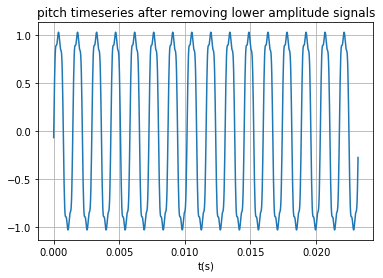

In [9]:


plt.figure(3)
# let's plot the cleaned up time series too - just for fun
plt.plot(t, y-y_filt)
plt.xlabel('t(s)')
plt.title('pitch timeseries after removing lower amplitude signals')
plt.grid()

# 2D DFTs

* Suppose we have a sample grid that is $M \times N$ with sample values $y_{mn}$.
* The 2D DFT works as follows:

* Fourier transform the $M$ rows:
$$c'_{m\ell} = \sum_{n=0}^{N-1}y_{mn}\exp\left(-i\frac{2\pi \ell n}{N}\right)$$

Fourier transform the $N$ cols to get 2D DFT:
$$c_{k\ell} = \sum_{m=0}^{M-1}c'_{m\ell}\exp\left(-i\frac{2\pi km}{M}\right) = \sum_{k=0}^{M-1}\sum_{n=0}^{N-1} y_{mn} \exp\left[-i 2\pi\left(\frac{km}{M} + \frac{\ell n}{N}\right)\right].$$

Inverse 2D DFT:
$$y_{mn} = \frac{1}{MN}\sum_{k=0}^{M-1}\sum_{\ell=0}^{N-1}c_{kl}\exp\left[i 2\pi\left(\frac{km}{N} + \frac{\ell n}{N}\right)\right].$$